In [6]:
from numpy import array, abs, arange, dot, int8, int32, floor, fromfunction,\
                  hypot, ones, prod, random, indices, newaxis, poly1d
from PIL import Image

class PerlinNoise(object):

    def noise(self, coords):

        ijk = (floor(coords) + self.idx_ar).astype(int8)

        uvw = coords - ijk

        indexes = self.P[ijk[:,:, self.order - 1]]

        for i in range(self.order - 1):
            indexes = self.P[(ijk[:,:, i] + indexes) % len(self.P)]

        gradiens = self.G[indexes % len(self.G)]
#        gradiens = self.G[(ijk[:,:, 0] + indexes) % len(self.G)]
        
        res = (self.drop(abs(uvw)).prod(axis=2)*prod([gradiens, uvw], axis=0).sum(axis=2)).sum(axis=1)

        res[res > 1.0] = 1.0
        res[res < -1.0] = -1.0

        return ((res + 1)*128).astype(int8)

    def getData(self, scale=32.0):
        return self.noise(indices(self.size).reshape(self.order, 1, -1).T / scale)

    def getImage(self, scale=32.0):
        return Image.frombuffer('L', self.size[:2], 
                                self.getData(scale)[ : self.size[0]*self.size[1]],
                                'raw', 'L', 0, 1)

    def saveImage(self, fileName, scale=32.0):
        im = self.getImage(scale)
        im.save(fileName)

    def __init__(self, size=None, n=None):

        n = n if n else  256        
        self.size = size if size else (256, 256)

        self.order = len(self.size)
        
        # Generate WAY more numbers than we need
        # because we are throwing out all the numbers not inside a unit
        # sphere.  Something of a hack but statistically speaking
        # it should work fine... or crash.
        G = (random.uniform(size=2*self.order*n)*2 - 1).reshape(-1, self.order)

        # GAH! How do I generalize this?!
        #length = hypot(G[:,i] for i in range(self.order))

        if self.order == 1:
            length = G[:,0]
        elif self.order == 2:
            length = hypot(G[:,0], G[:,1])
        elif self.order == 3:
            length = hypot(G[:,0], G[:,1], G[:,2])
        
        self.G = (G[length < 1] / (length[length < 1])[:,newaxis])[:n,]
        self.P = arange(n, dtype=int32)
        
        random.shuffle(self.P)
        
        self.idx_ar = indices(2*ones(self.order), dtype=int8).reshape(self.order, -1).T
        self.drop = poly1d((-6, 15, -10, 0, 0, 1.0))



In [5]:
from pylab import *
%matplotlib inline

/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2000: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  res = empty((N,)+dimensions, dtype=dtype)
/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2003: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp.shape = (1,)*i + (dim,)+(1,)*(N-i-1)
/home/alex/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:2005: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val = zeros(newdim, dtype)


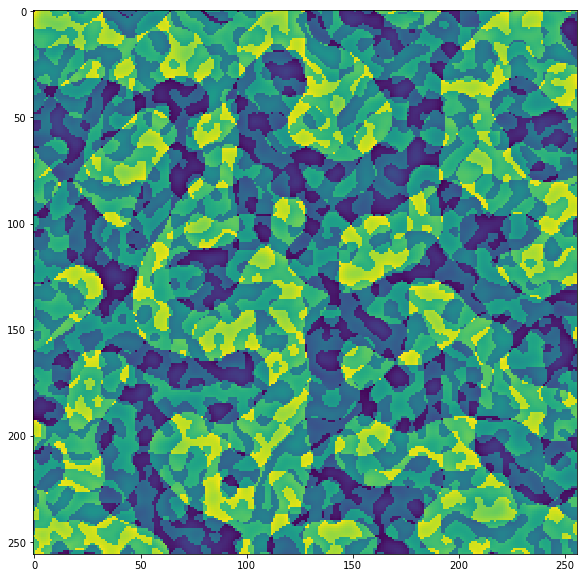

In [20]:
pn = PerlinNoise(size=(256, 256))
image = 1.0 * pn.getData(scale=32).reshape((256, 256))
image += (0.8**1) * pn.getData(scale=16).reshape((256, 256))
image += (0.8**2) * pn.getData(scale=8).reshape((256, 256))
# image += (0.8**3) * pn.getData(scale=4).reshape((256, 256))
# image += (0.8**4) * pn.getData(scale=2).reshape((256, 256))
figure(figsize=(10,10))
imshow(image)

In [ ]:
if __name__ == "__main__":
    # 1D Noise
    n = PerlinNoise(size=(1, 128))
    n.saveImage('PerlinNoise-1D.png')

    # 2D Noise
    n = PerlinNoise(size=(128, 128))
    n.saveImage('PerlinNoise-2D.png')

    # 3D Noise
    # It is preferable to get the 3D noise data and manipulate it yourself
    # since saving it as an image might have some strange results (for non-1 3d dimenison
    n = PerlinNoise(size=(128, 128, 1))
    n.saveImage('PerlinNoise-3D.png')